In [9]:
import numpy as np
import json
import csv
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import lightgbm as lgb
from sklearn import svm
import xgboost as xgb

from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [10]:
def load_data(y):
    path = '../../data/std_data/'
    x_train_std = pd.read_pickle(path +'train/{}_x.pkl'.format(str(y))).values
    x_test_std = pd.read_pickle(path +'test/{}_x.pkl'.format(str(y))).values
    y_train = pd.read_pickle(path +'train/{}_y.pkl'.format(str(y))).values
    y_test = pd.read_pickle(path +'test/{}_y.pkl'.format(str(y))).values
    features = pd.read_pickle(path +'train/{}_x.pkl'.format(str(y))).columns
    return x_train_std, x_test_std, y_train, y_test, features

In [11]:
def plot_roc_curve(fpr, tpr, auc):
    # ROC曲線をプロット
    plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
    plt.legend()
    plt.title('ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)
    plt.show()

In [12]:
def main():
    
    
    cm_all = np.zeros((2, 2))
    
    # 予測した確率全体を格納
    probs_all_lr = np.array([])
    probs_all_lda = np.array([])
    probs_all_sv = np.array([])
    probs_all_lgbm = np.array([])
    probs_all_xgb = np.array([])
    probs_all = np.array([])
    
    y_true_all = np.array([])
    
    for y in range(1978, 2020):
        
        # データの生成
        x_train_std, x_test_std, y_train, y_test, features = load_data(y)
        y_true_all = np.hstack((y_true_all, y_test))
       
        # logistic regression
        lr = LogisticRegression(class_weight="balanced", solver="liblinear",  penalty="l2", C=0.0001) # ロジスティック回帰モデルのインスタンスを作成
        lr.fit(x_train_std, y_train) # ロジスティック回帰モデルの重みを学習
        probs_lr = lr.predict_proba(x_test_std)
        probs_all_lr = np.hstack((probs_all_lr, probs_lr[:,1]))
        
        # LDA
        lda = LDA(solver="eigen", shrinkage=1).fit(x_train_std,  y_train)
        probs_lda = lda.predict_proba(x_test_std)
        probs_all_lda = np.hstack((probs_all_lda, probs_lda[:,1]))
        
        # svm
        sv = svm.SVR(kernel="sigmoid",
                                     degree=4,
                                     gamma=0.043502212815589775,
                                     coef0=0.20190829020616494,
                                     tol=0.0001,
                                     C=0.000245786293391316,
                                     epsilon=0.3056167642389302,
                                    verbose=True,)
        sv.fit(x_train_std, y_train)
        probs_sv = sv.predict(x_test_std)
        probs_all_sv = np.hstack((probs_all_sv, probs_sv))
        
        # xgb
        xgboost = xgb.XGBRegressor(silent= True, 
                               max_depth=4,
                               learning_rate=0.12765177534095626,
                               n_estimators = 46,
                               gamma=0.060805284848630535,
                               reg_lambda=4.995675788308118,
                               reg_alpha=2.1912254426545754,
                               sub_sample=0.45297631180790854,
                               scale_pos_weight=1.1672978934986058)
        xgboost.fit(x_train_std, y_train)
        probs_xgb = xgboost.predict(x_test_std)
        probs_all_xgb = np.hstack((probs_all_xgb, probs_xgb))
        
        
        
        # lgbm
        lgbm = lgb.LGBMRegressor(
            random_state=0,
            verbosity=-1,
            bagging_seed=0,
            boost_from_average='true',
            metric='auc',
            bagging_freq=4,
            min_data_in_leaf=21,
            max_depth=13,
            learning_rate=0.08731913651405197,
            n_estimators=3394,
            subsample=0.7054763057027115,
            num_leaves=438,
            reg_lambda=0.9377125325944119,  
        )
        
        lgbm.fit(x_train_std, y_train)
        probs_lgbm = lgbm.predict(x_test_std)
        probs_all_lgbm = np.hstack((probs_all_lgbm, probs_lgbm))


        
        probs = (probs_lda[:,1] + probs_lr[:,1] + probs_sv + probs_xgb + probs_lgbm) * 0.2
        
        
        probs_all = np.hstack((probs_all, probs))
        print(probs)

        # 混同行列
        y_pred = np.where((probs ==  max(probs)), 1, 0) #確率→0/1
        cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
        cm_all += cm
    
    
    auc_lr = roc_auc_score(y_true_all, probs_all_lr)
    auc_lda = roc_auc_score(y_true_all, probs_all_lda)
    auc_sv = roc_auc_score(y_true_all, probs_all_sv)
    auc_xgb = roc_auc_score(y_true_all, probs_all_xgb)
    auc_lgbm = roc_auc_score(y_true_all, probs_all_lgbm)

    auc = roc_auc_score(y_true_all, probs_all)
    
    fpr, tpr, thresholds = roc_curve(y_true_all, probs_all)
    
    plot_roc_curve(fpr, tpr, auc)
    
    print("len: {0} , {1}".format(len(y_true_all), len(probs_all) ))
    print("confusion_matrix: ")
    print(cm_all)
    print("AUC all: ")
    print(auc)
    print("AUC LR: ")
    print(auc_lr)
    print("AUC LDA: ")
    print(auc_lda)
    print("AUC svm: ")
    print(auc_sv)
    print("AUC xgb: ")
    print(auc_xgb)
    print("AUC lgbm: ")
    print(auc_lgbm)
    print()
    return

[LibSVM][0.36481434 0.21291096 0.17057162 0.22430596 0.24427794]
[LibSVM][0.35530878 0.17343893 0.19657973 0.4396054  0.21401396]
[LibSVM][0.3467141  0.48608752 0.22687637 0.31768299 0.17309026]
[LibSVM][0.18001367 0.19019663 0.1867222  0.18274976 0.31527678]
[LibSVM][0.33527052 0.35132118 0.29885581 0.52364349 0.17534903]
[LibSVM][0.57304008 0.18591239 0.18314066 0.2701307  0.19864216]
[LibSVM][0.17515292 0.34615188 0.21070553 0.30715601 0.20391562]
[LibSVM][0.34758813 0.20527697 0.34567134 0.19802683 0.12336476]
[LibSVM][0.17579137 0.17035741 0.2941869  0.31234658 0.33540736]
[LibSVM][0.21377237 0.20889899 0.27256151 0.16375923 0.2775529 ]
[LibSVM][0.56683505 0.17327204 0.16156019 0.24769028 0.20977836]
[LibSVM][0.19437675 0.22741738 0.16981395 0.41523882 0.2004922 ]
[LibSVM][0.64895164 0.19223263 0.22623035 0.2444346  0.18505014]
[LibSVM][0.58891131 0.33462018 0.20961494 0.1581451  0.23066346]
[LibSVM][0.78640697 0.28820633 0.30147524 0.26058465 0.17594156]
[LibSVM][0.65823543 0.241

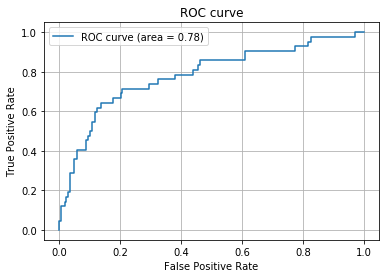

len: 211 , 211
confusion_matrix: 
[[149.  20.]
 [ 20.  22.]]
AUC all: 
0.7827557058326288
AUC LR: 
0.7482389405466329
AUC LDA: 
0.7418991265145111
AUC svm: 
0.794590025359256
AUC xgb: 
0.7607072414764722
AUC lgbm: 
0.7602141448295294



In [13]:
main()